In [1]:
#loading the library
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#read data from web
players_data <- read_csv("https://raw.githubusercontent.com/thaviship/individual-planning-dsci-100/refs/heads/main/players.csv", 
                         col_names=TRUE)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Questions chosen

**Broad question chosen**: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

**Specific question chosen**: Which player characteristics are associated with higher gameplay hours among players who contribute at least some data?

## Data Description

The dataset contains 196 observations and 6 variables describing player demographics and gameplay activity. 

|Variable Name | Type | Description |
|--------------| -----| ------------|
|experience | categorical (factor) | Player's experience level|
|subscribe | categorical (logical) | Whether or not the player has a game subscription (subscribed= TRUE)|
|hashedEmail | String | A hashed version of the player's email address. Not useful for modelling|
|played_hours | numeric (continuous) | Total hours the player spent playing the game. This is the **response variable**|
|name| String/Categorical | Player's chosen name on game server. Not useful for modelling|
|gender| Categorical (factor) | Self reported gender category of the players |
|age| Numeric (integer) | Player's age in years|

### Potential Issues in Dataset

Several issues occur in the data, including duplicate entries, inconsistent gender labeling, missing values in the age column, and unnecessary identifier variables such as hashedEmail and name. 

A large portion of the dataset also consists of players with zero recorded gameplay hours, who contribute no usable data for behavioral modeling. Since the goal of this project is specifically to identify which groups contribute more gameplay data—not simply who logs in—the analysis focuses on players who have played more than zero hours. Therefore, the dataset needs to be tidied in order to answer the predictive question accurately.

### Tidying the dataset

1. Select out the hashedEmail and name column vectors as they are identifiers and contain no predictive information.
2. Convert subscribe, experience, and gender character variables to factor variables so that R can treat them as categorical variables.
4. Filter out the played_hours variable and select only those who have >0 gameplay hours. Zero-hour players are non-contributors and do not contribute to the goal of identifying high-engagement users.
5. Filter out gender categories that appear less than 5 times,as these data points will be meaningless when using model prediction and they can also result in coefficients with giant uncertainties.
6. Remove rows with missing Age, as leaving NA values leads to loss of rows silently and inconsistencies in model prediction.
7. To deal with extreme outliers in played_hours, transform highly skewed values into log as it compresses the large values, which makes the distribution closer to normal and stabilizes variance. Consequently, it will improve linear model fit and produce more meaningful coefficients.


In [3]:
#tidy data
players_tidy <- players_data |> 
                select(-hashedEmail, -name) |> 
  mutate(subscribe_fct=as_factor(subscribe)) |> 
  mutate(experience_fct=as_factor(experience)) |>
mutate(gender_fct=as_factor(gender)) |>
                filter(played_hours>0) |> 
         filter(!is.na(Age)) |>   
         mutate(gender_fct = fct_lump_min(gender_fct, min = 5)) |>
         mutate(played_hours_log = log(played_hours + 1))
               

#remove non fct columns to prevent multicollinearlity when performing multivariable linear regression

players_clean<- players_tidy |> select(experience_fct, subscribe_fct, gender_fct, Age, played_hours_log)

players_clean

experience_fct,subscribe_fct,gender_fct,Age,played_hours_log
<fct>,<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,Male,9,3.44361810
Veteran,TRUE,Male,17,1.56861592
Amateur,TRUE,Female,21,0.53062825
Regular,TRUE,Male,21,0.09531018
Amateur,TRUE,Male,47,0.09531018
Veteran,TRUE,Female,23,0.95551145
Beginner,TRUE,Female,25,0.91629073
Amateur,TRUE,Male,22,0.18232156
Amateur,TRUE,Female,17,3.89995042


## Visualisation 

### 1. Distribution of Played Hours by Experience Level and Subscribers

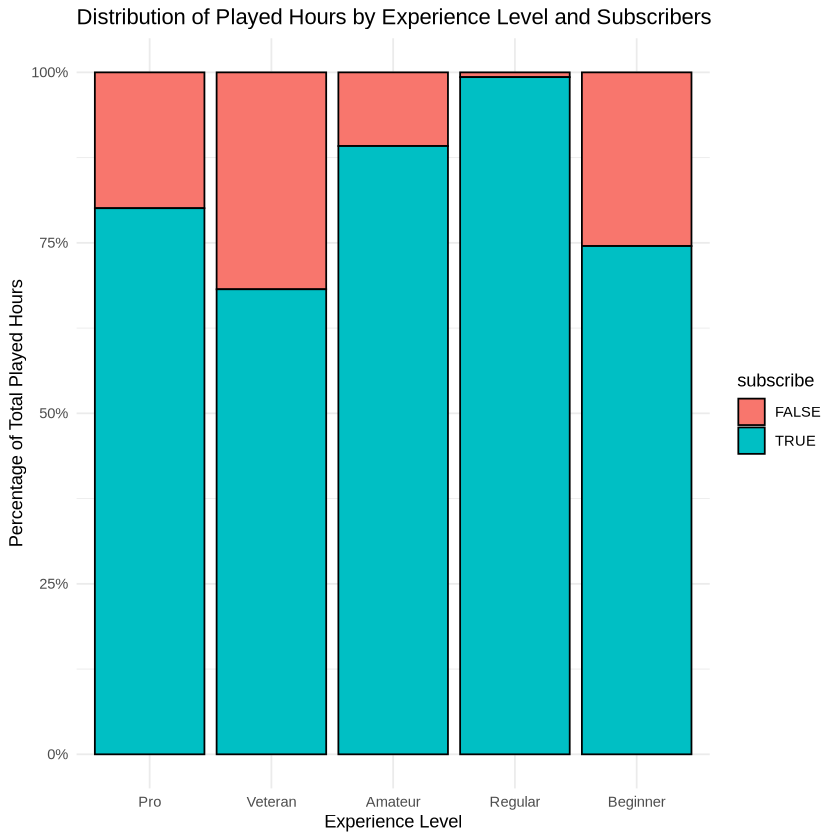

In [4]:
plot_data <- players_clean |>
  group_by(experience_fct, subscribe_fct) |>
  summarise(total_hours = sum(played_hours_log), .groups = "drop") |> group_by(experience_fct) |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct <- ggplot(plot_data,
                                         aes(x = experience_fct,
                                             y = percentage,fill=subscribe_fct)) +
  geom_bar(stat = "identity", position = "fill", colour="black") +
  scale_y_continuous(labels = percent_format()) +
  labs(
    x = "Experience Level",
    y = "Percentage of Total Played Hours",
    title = "Distribution of Played Hours by Experience Level and Subscribers",
fill="subscribe") +
  theme_minimal()

experience_gender_percent_plot_fct

#### Insight: 

The bar plot shows that subscription status is strongly related with higher gameplay hours. Across all experience levels, subscribers contributes the vast majority of total played hours which indicates that being a subscriber is one of the clearest predictors of heavy engagement. However experience level variable still plays a major role as the visualisation depicts that more advanced groups like Pro and Regular tend to show higher total hours but the dominant trend is that subscribers constently play more regardless of their experience category. 

### 2. Distribution of Played hours by Gender

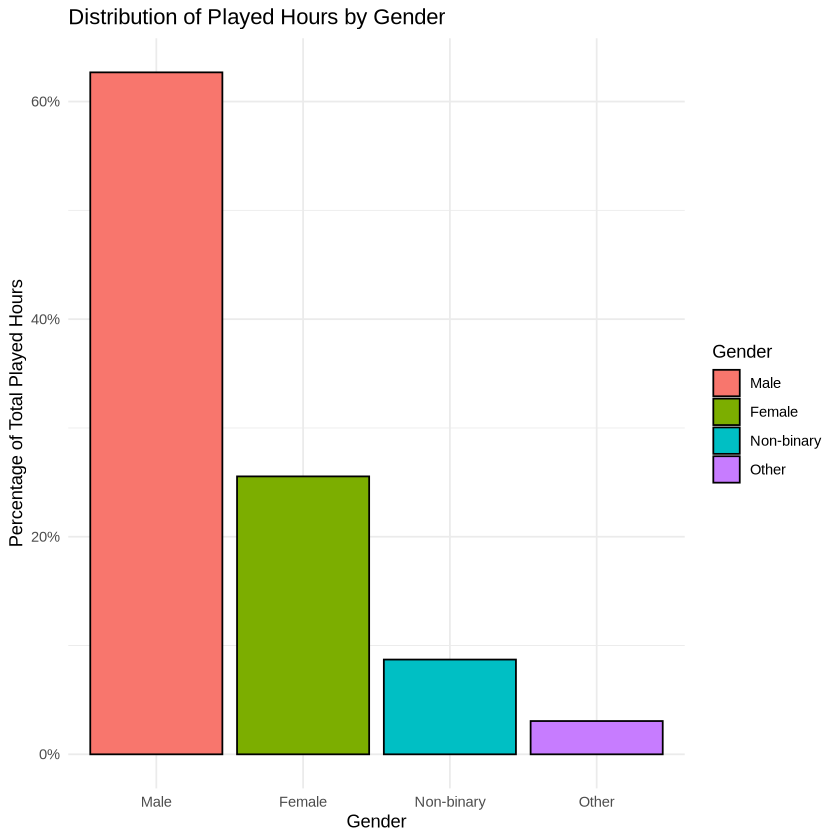

In [5]:
plot_data <- players_clean |>
  group_by(gender_fct) |> filter(gender_fct!="Prefer not to say") |>
  summarise(total_hours = sum(played_hours_log), .groups = "drop") |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct <- ggplot(plot_data,
                                             aes(x = gender_fct,
                                                 y = percentage, fill=gender_fct)) +
  geom_bar(stat = "identity", colour = "black") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    x = "Gender",
    y = "Percentage of Total Played Hours",
    title = "Distribution of Played Hours by Gender",
  fill="Gender") +
  theme_minimal()

experience_gender_percent_plot_fct


#### Insight:

This bar plot clearly shows that the male category within the gender variable clearly dominates when it comes to percentage of total hours played, followed by women. 

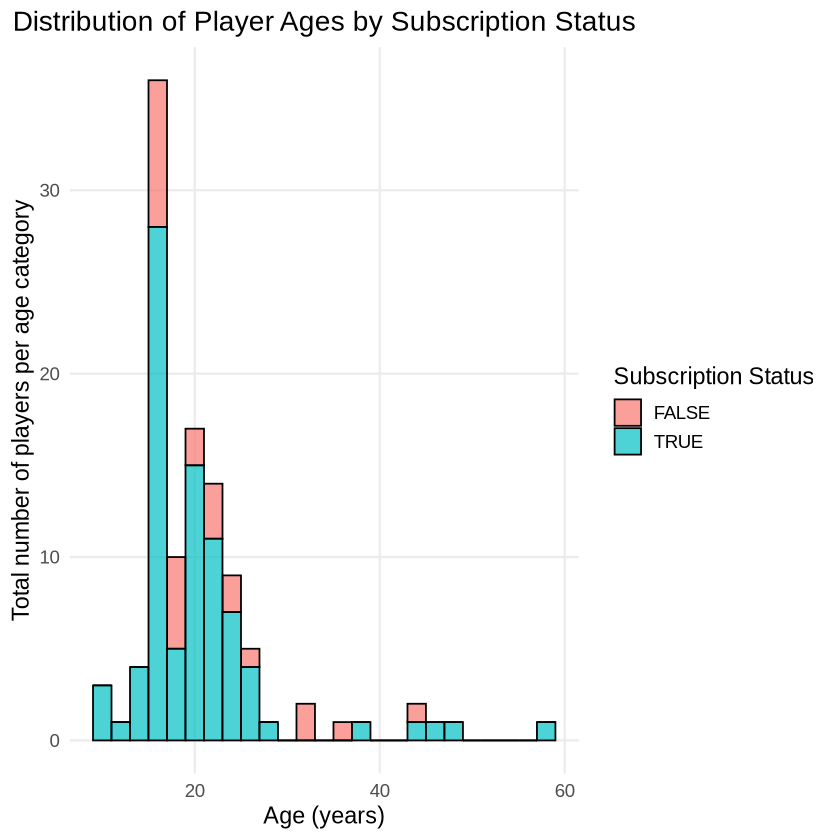

In [6]:
players_age_hours_hist <- players_clean |> 
   ggplot(aes(x = Age, fill = subscribe_fct)) +
  geom_histogram(binwidth = 2,color="black", alpha=0.7) +
  labs(
    title = "Distribution of Player Ages by Subscription Status",
    x = "Age (years)",
    y = "Total number of players per age category",
    fill = "Subscription Status"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "right",
    panel.grid.minor = element_blank())
  
players_age_hours_hist

experience_fct,total_hours
<fct>,<dbl>
Pro,7.590369
Veteran,13.301916
Amateur,36.530174
Regular,27.261411
Beginner,14.002397


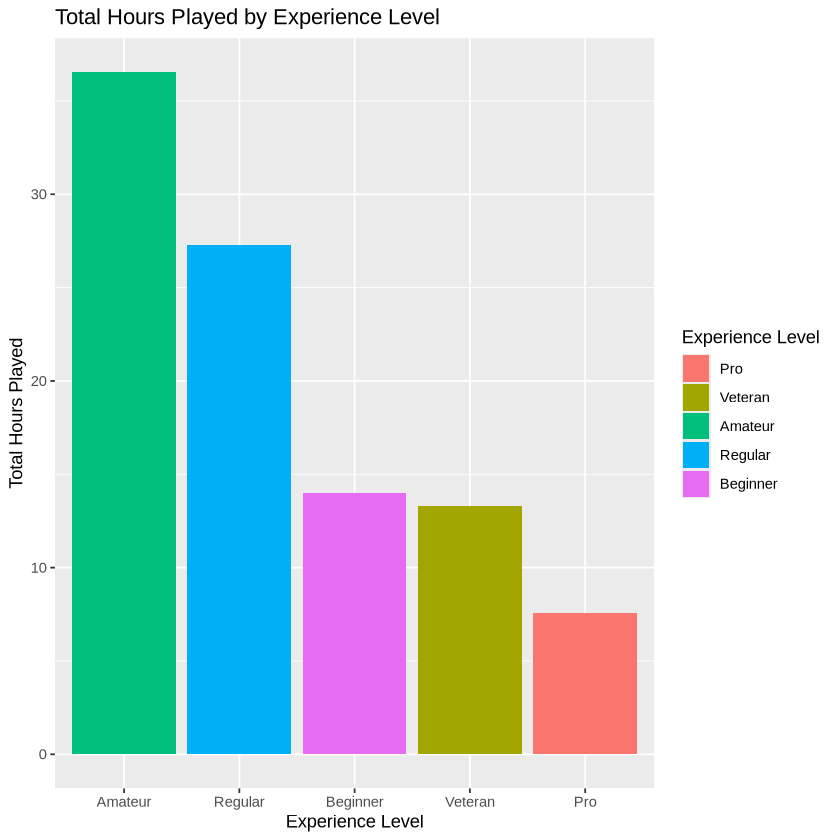

In [7]:
bar_plot_tidy_players <- players_clean |>
  group_by(experience_fct) |>
  summarise(total_hours = sum(played_hours_log), .groups = "drop")
bar_plot_tidy_players

bar_plot_experience_vs_totalhrs <- bar_plot_tidy_players |> 
  ggplot(aes(x = fct_reorder(experience_fct, total_hours, .desc=TRUE),
             y = total_hours,
             fill = experience_fct)) +
  geom_bar(stat = "identity") +
  labs(x = "Experience Level", 
       y = "Total Hours Played", 
       fill = "Experience Level",title = "Total Hours Played by Experience Level")

bar_plot_experience_vs_totalhrs

## Methods and Plan

To address the predictive question, a multivariable linear regression model that predicts gameplay hours using subscribe, experience level, gender, and age variables among players who have contributed some gameplay time(played_hours>0) will be used. 

This method is appropriate as the response variable played_hours is continuous, which makes linear regression suitable. The predictors include gender, experience, and subscribe, which are categorical variables, and age, which is a numerical variable, all of which are dummy variables that regression can handle. Moreover, linear regression allows for an estimation of how each predictor variable is associated with changes in gameplay hours while controlling for other variables.

Some assumptions required will be that each predictor should have a linear relationship with the outcome (possibly after transformation), and each row represents a separate participant, which is reasonable. The distribution of errors should be approximately normal. Predictors should also not be perfectly or highly correlate,d which is why only the mutated factor variables for gender, subscribe, and experience were selected. 

Some potential limitations of this model involve the fact that some predictions can influence gameplay in a non-linear way, and therefore, linear regression might oversimplify these relationships. In addition to that, even though a log transformation has been used to mutate the played_hours variable, very high gameplay hours can still somehow distort the model.

As such, the model needs to be compared with kNN multivariable regression, where the model will be tuned using the value of K by first performing cross-validation of the training data set to choose the optimal  K. The K value with the minimum RMSPE is used to find the best setting for the number of neighbors and create a recipe to predict which predictor variable can best be used to identify players with high gameplay hours. 

Before applying the data to the model, the dataset should be split into training and testing data sets, training:80% and testing: 20%. This prevents information from the test set from leaking into the model.

Within the training data set, a cross-validation using 5-fold cross-validation should be used to ensure stable estimates and prevent overfitting. The cross-validation results will be used to compare model variations.

The model is then used to compare the RMSE value and to obtain the multivariable linear regression line. 


